In [1]:
lang='italian'
exp_dir='/mnt/conll/exp-data'
bpe_n=1000
batch_size=4
beam_size=1
#gold
gold_file='{}/{}/{}-dev'.format(exp_dir,lang,lang)


def print_errors(pred_file, gold_file):
    pred_f=open(pred_file)
    gold_f=open(gold_file)
    for i,(pred_line,gold_line) in enumerate(zip(pred_f,gold_f)):
    #if i==0:
        lemma, infl, msd = pred_line.strip().split('\t')
        _, infl_g, _ = gold_line.strip().split('\t')
        if infl!=infl_g:
            print(lemma, infl_g, msd, infl)
        #print(lemma, infl, msd, infl_g, infl==infl_g)
    

In [2]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# unscaled alignments scaled with gate 
def unscaled_al_heatmap(attn_data,ind):
    # input data
    src = attn_data[ind]['src']
    trg = attn_data[ind]['pred']
    msd = attn_data[ind]['inflection']
    gate_v = attn_data[ind]['attn']['gate']
    l_v = attn_data[ind]['attn']['lemma']
    f_v = attn_data[ind]['attn']['inflection']

    all_al=torch.cat((l_v,gate_v,f_v), dim=1)
    all_src = src + ['lemma', 'msd']+ msd
    fig = plt.figure(figsize=(8,8))
    r = sns.heatmap(all_al, cmap='BuPu',cbar=False,xticklabels=all_src,yticklabels=trg)
    r.set_yticklabels(r.get_yticklabels(), rotation=0)
    r.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
    r.set_title("Heatmap: Unscaled alignments and gate")
    return

# unscaled alignments scaled with gate
def scaled_al_heatmap(attn_data,ind,save_file=None):
    # input data
    src = attn_data[ind]['src']
    trg = attn_data[ind]['pred']
    msd = attn_data[ind]['inflection']
    gate_v = attn_data[ind]['attn']['gate']
    l_v = attn_data[ind]['attn']['lemma']
    f_v = attn_data[ind]['attn']['inflection']

    lemma_weights = gate_v[:, 0].unsqueeze(1)
    infl_weights = gate_v[:, 1].unsqueeze(1)

    al_l_scaled = l_v * lemma_weights
    al_f_scaled = f_v * infl_weights
    al_scaled = torch.cat([al_l_scaled, al_f_scaled], dim=1)

    all_src = src + msd

    fig = plt.figure(figsize=(8,8))
    r = sns.heatmap(al_scaled, cmap='BuPu',cbar=False,xticklabels=all_src,yticklabels=trg)
    r.set_yticklabels(r.get_yticklabels(), rotation=0)
    r.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
    
    if save_file is not None:
        plt.tight_layout()
        fig.savefig(save_file)
        
    else:
        r.set_title("Heatmap: Scaled alignments")
    return

In [6]:
# unscaled alignments - GGH model
def unscaled_al_ggh_heatmap(attn_data,ind, fused_msd=False, 
                            bpe=False, bpe_data=None,n_global_heads=None,save_file=None):
    # input data
    src = attn_data[ind]['src']
    trg = attn_data[ind]['pred']
    msd = attn_data[ind]['inflection']
    gate_v = attn_data[ind]['attn']['gate']
    l_v = attn_data[ind]['attn']['lemma']
    f_v = attn_data[ind]['attn']['inflection']
    
    if not n_global_heads:
        l_g_v = attn_data[ind]['attn']['gate_lemma_global']
    else:
        l_g_v = []
        for n in range(n_global_heads):
            att_key = 'gate_lemma_global_'+str(n)
            l_g_v.append(attn_data[ind]['attn'][att_key])
        l_g_v = torch.cat(l_g_v, dim=0)
    if bpe:
        all_al=torch.cat((l_v,gate_v,f_v), dim=1)
    else:
        all_al=torch.cat((l_v,gate_v,f_v), dim=1)
    
        n_cols = all_al.size()[1]
        zero_pad = torch.zeros(1,n_cols-l_g_v.size()[1])
        l_g_v_pad = torch.cat((l_g_v,zero_pad), dim=1)
        all_al = torch.cat((l_g_v_pad,all_al),dim=0)
                          

    #all_al=torch.cat((l_v,l_g_v,gate_v,f_g_v,f_v), dim=1)
    if fused_msd:
        all_src = src + ['g_l', 'g_msd'] + msd + ['msd']
    else:
        all_src = src + ['g_l', 'g_msd'] + msd
        
    if bpe:
        all_trg = trg
    else:
        all_trg = ['ggh']+trg
    
    fig = plt.figure(figsize=(8,8))
    r = sns.heatmap(all_al, cmap='BuPu',cbar=False,xticklabels=all_src,yticklabels=all_trg)
    r.set_yticklabels(r.get_yticklabels(), rotation=0)
    r.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
    r.set_title("Heatmap: Unscaled alignments and gate")
    
    if bpe:
        bpe_src = open(bpe_data).readlines()[ind].strip().split('|')
        if not n_global_heads:
            y_labels = ['ggh']
        else:
            y_labels = ['ggh_'+str(n) for n in range(n_global_heads)]
            
        fig = plt.figure(figsize=(3,3))
        r = sns.heatmap(l_g_v, cmap='BuPu',cbar=False,xticklabels=bpe_src,yticklabels=y_labels)
        r.set_yticklabels(r.get_yticklabels(), rotation=0)
        r.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
        r.set_title("Heatmap: Gate global alignments")
    return

# unscaled alignments scaled with gate  - GGH model
def scaled_al_ggh_heatmap(attn_data,ind, fused_msd=False, 
                          bpe=False, bpe_data=None,n_global_heads=None, mixed=False,save_file=None):
    # input data
    src = attn_data[ind]['src']
    trg = attn_data[ind]['pred']
    msd = attn_data[ind]['inflection']
    gate_v = attn_data[ind]['attn']['gate']
    l_v = attn_data[ind]['attn']['lemma']
    f_v = attn_data[ind]['attn']['inflection']
    
    lemma_weights = gate_v[:, 0].unsqueeze(1)
    infl_weights = gate_v[:, 1].unsqueeze(1)

    al_l_scaled = l_v * lemma_weights
    al_f_scaled = f_v * infl_weights
    
    if not n_global_heads:
        l_g_v = attn_data[ind]['attn']['gate_lemma_global']
    else:
        if not mixed:
            l_g_v = []
            for n in range(n_global_heads):
                att_key = 'gate_lemma_global_'+str(n)
                l_g_v.append(attn_data[ind]['attn'][att_key])
            l_g_v = torch.cat(l_g_v, dim=0)
        else:
            l_g_v_subw = []
            l_g_v_char = []
            for n in range(n_global_heads):
                att_key = 'gate_lemma_subw_global_'+str(n)
                l_g_v_subw.append(attn_data[ind]['attn'][att_key])
                att_key = 'gate_lemma_char_global_'+str(n)
                l_g_v_char.append(attn_data[ind]['attn'][att_key])
            l_g_v_subw = torch.cat(l_g_v_subw, dim=0)
            l_g_v_char = torch.cat(l_g_v_char, dim=0)
    
    if bpe:
        all_al=torch.cat((al_l_scaled,al_f_scaled), dim=1)
    else:
        all_al=torch.cat((al_l_scaled,al_f_scaled), dim=1)
        n_cols = all_al.size()[1]
        zero_pad = torch.zeros(1,n_cols-l_g_v.size()[1])
        l_g_v_pad = torch.cat((l_g_v,zero_pad), dim=1)
        all_al = torch.cat((l_g_v_pad,all_al),dim=0)
 
    #al_scaled = torch.cat([al_l_scaled, l_g_v,f_g_v, al_f_scaled], dim=1)

    if fused_msd:
        all_src = src + msd + ['msd']
    else:
        all_src = src + msd
    if bpe:
        all_trg=trg
    else:
        all_trg = ['ggh']+trg

    fig = plt.figure(figsize=(8,8))
    r = sns.heatmap(all_al, cmap='BuPu',cbar=False,xticklabels=all_src,yticklabels=all_trg)
    r.set_yticklabels(r.get_yticklabels(), rotation=0)
    r.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
    if save_file is not None:
        plt.tight_layout()
        fig.savefig(save_file+'.ch-al'+'.png')
    else:
        r.set_title("Heatmap: Scaled alignments")
    
    if bpe:
        bpe_src = open(bpe_data).readlines()[ind].strip().split('|')
        if not mixed:           
            if not n_global_heads:
                y_labels = ['ggh']
            else:
                y_labels = ['ggh_'+str(n) for n in range(n_global_heads)]
            fig = plt.figure(figsize=(3,1))
            r = sns.heatmap(l_g_v, cmap='BuPu',cbar=False,xticklabels=bpe_src,yticklabels=y_labels)
            r.set_yticklabels(r.get_yticklabels(), rotation=0)
            r.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
            if save_file is not None:
                plt.tight_layout()
                fig.savefig(save_file+'.sub-al'+'.png')
            else:
                r.set_title("Heatmap: Gate global alignments")
        else:
            y_labels = ['ggh_'+str(n) for n in range(n_global_heads)]
            # subwords
            
            fig = plt.figure(figsize=(3,1))
            r = sns.heatmap(l_g_v_subw, cmap='BuPu',cbar=False,xticklabels=bpe_src,yticklabels=y_labels)
            r.set_yticklabels(r.get_yticklabels(), rotation=0)
            r.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
            if save_file is not None:
                plt.tight_layout()
                fig.savefig(save_file+'.sub-al'+'.png')
            else:
                r.set_title("Heatmap: Gate global alignments")
            
            # chars
            fig = plt.figure(figsize=(3,1))
            r = sns.heatmap(l_g_v_char, cmap='BuPu',cbar=False,xticklabels=src,yticklabels=y_labels)
            r.set_yticklabels(r.get_yticklabels(), rotation=0)
            r.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
            if save_file is not None:
                plt.tight_layout()
                fig.savefig(save_file+'.sub-al'+'.png')
            else:
                r.set_title("Heatmap: Gate global alignments")
            
    return

In [7]:
def ex2pattern(src,trg,msd,al_ind):
    # 1. collect type of operations per src_pos (if lemma involved) or msd_pos (only msd is onvolved)
    src_op_map={} 
    msd_op_map={}
    # go over inflected form
    for i_trg,ch_trg in enumerate(trg[:-1]):
        # select salient al-t at pos i_trg:
        al_src, al_msd = al_ind[i_trg]
        #al_src = al_src.item()
        #al_msd = al_msd.item()
        # check operation type
        if src[al_src]==trg[i_trg]: # copy operation
            if al_src!=-1:
                al = ((al_src,al_msd), i_trg)
                # if aligned to lemma char (plus, possible, msd), save to src_op_map
                if al_src not in src_op_map:
                    src_op_map[al_src]={'c':[], 'g':[]}
                src_op_map[al_src]['c'].append(al)
            else:
                al = (al_msd, i_trg)
                # align to msd
                if al_msd not in msd_op_map:
                    msd_op_map[al_msd]=[]
                msd_op_map[al_msd].append(al)
        else:
            if al_src!=-1:
                al = ((al_src,al_msd), i_trg)
                # if aligned to lemma char (plus, possible, msd), save to src_op_map
                if al_src not in src_op_map:
                    src_op_map[al_src]={'c':[], 'g':[]}
                src_op_map[al_src]['g'].append(al)
            else:
                # align to msd
                al = (al_msd, i_trg)
                if al_msd not in msd_op_map:
                    msd_op_map[al_msd]=[]
                msd_op_map[al_msd].append(al)
            
    # 2. index operations and map src and trg positions to masks 
    c_ind = 0
    g_ind = 0
    prev_c_trg=-2 # target position of last copy operation
    prev_c_src=-2 # lemma alignment of last copy operation
    prev_c_f=-2 # msd alignment of last copy operation
    prev_g_trg=-2 # target position of last generation operation
    prev_g_src=-2 # alignment of last generation operation
    prev_g_f=-2 # msd alignment of last generation operation

    src_map = {}
    trg_map = {}

    def masks(op_ind, op, al_msd):
        mask = op+str(op_ind)
        if al_msd==-1:
            return mask, mask
        else:
            return mask, '{'+mask+'f'+str(al_msd)+'}'

    # go over lemma
    for pos in range(len(src)):
        if pos in src_op_map:
            # check for 1-1 copy
            if len(src_op_map[pos]['c'])==1 and len(src_op_map[pos]['g'])==0:
                (al_src,al_msd), i_trg = src_op_map[pos]['c'][0]
                # adjacent copy?
                if prev_c_trg+1==i_trg and prev_c_src+1==al_src and prev_c_f==al_msd:
                    prev_c_trg+=1
                    prev_c_src+=1
                else:
                    c_ind+=1
                    prev_c_trg=i_trg
                    prev_c_src =al_src
                    prev_c_f=al_msd  
                src_mask, trg_mask = masks(c_ind, 'c', al_msd)
                src_map[al_src]=src_mask
                trg_map[i_trg]=trg_mask
            else:
                # index copy operations
                if len(src_op_map[pos]['c'])==0:
                    src_copy_mask=''
                else:
                    src_comb_ind=[]
                    for (al_src,al_msd), i_trg in src_op_map[pos]['c']:
                        c_ind+=1
                        _, trg_mask = masks(c_ind, 'c', al_msd)
                        trg_map[i_trg]=trg_mask
                        src_comb_ind.append(str(c_ind))
                    src_copy_mask = 'c'+';'.join(src_comb_ind)
                # index generation operation
                if len(src_op_map[pos]['g'])==0:
                    src_gen_mask=''
                else:
                    src_comb_ind=[]
                    for (al_src,al_msd), i_trg in src_op_map[pos]['g']:
                        # adjacent 1-to-many generation?
                        if prev_g_trg+1==i_trg and prev_g_src==al_src and prev_g_f==al_msd:
                            prev_g_trg+=1
                        else:
                            g_ind+=1
                            prev_g_trg=i_trg
                            prev_g_src=al_src
                            prev_g_f=al_msd
                        
                        _, trg_mask = masks(g_ind, 'g', al_msd)
                        trg_map[i_trg]=trg_mask
                        src_comb_ind.append(str(g_ind)) 
                    src_gen_mask = 'g'+';'.join(src_comb_ind)
                src_map[al_src]=src_copy_mask+src_gen_mask 
                if len(src_gen_mask)>0 and len(src_copy_mask)>0:
                    src_map[al_src]='{'+ src_map[al_src]+'}'
                        
    # go over MSD and index generation operations aligned to MSD only
    f_ind={}
    f_prev_trg={}
    for pos in range(len(msd)):
        if pos in msd_op_map:
            for al_msd,i_trg in msd_op_map[pos]:
                if al_msd not in f_prev_trg:
                    f_prev_trg[al_msd]=i_trg
                    f_ind[al_msd]=0
                else:
                    if i_trg!=f_prev_trg[al_msd]+1:
                        f_ind[al_msd]+=1
                f_prev_trg[al_msd]=i_trg
                trg_mask='f'+str(al_msd)+'_'+str(f_ind[al_msd])
                trg_map[i_trg]=trg_mask
            
            
    # mask src and target, group adjacent 1-to-1 copy and 1-to-many generations
    mask2src={}
    src_pat=[]
    for pos in range(len(src)):
        if pos in src_map:
            mask = src_map[pos]
            if len(src_pat)!=0 and src_pat[-1]==mask:
                mask2src[mask]+=src[pos]
            else:
                mask2src[mask]=src[pos]
                src_pat.append(mask)
        else:
            src_pat.append(src[pos])
    #src_pat = ' '.join(src_pat)

    mask2trg ={}
    trg_pat=[]
    for pos in range(len(trg[:-1])):
        mask = trg_map[pos]
        if len(trg_pat)!=0 and trg_pat[-1]==mask:
            mask2trg[mask]+=trg[pos]
        else:
            trg_pat.append(mask)
            mask2trg[mask]=trg[pos]
    #trg_pat = ' '.join(trg_pat)
    
    return src_pat, trg_pat, mask2src, mask2trg, trg_map, src_map
    

In [8]:
def data2patterns(data, allow_double_al=True):
    '''
    Data is data from torch with fileds:'src', 'pred', 'inflection', 'attn'
    'src': ['н', 'а', 'с', 'ы', 'л', 'а', 'т', 'ь'],
    'pred': ['н', 'а', 'с', 'ы', 'л', 'а', 'в', 'ш', 'и', 'й', '</s>']
    'attn' - has thre fields 'gate', 'lemma', 'inflection' containing sparsemax layers
    
    Returns list of patterns, each pattern has fields:
    al_pat - masked pattern with fused output char with the same als 
                #'c1 т ь --> c1 в ш ий </s>'
    al_list - list of salient non-copy alignemnts 
                # [('ACT', 'в'), ('PST', 'ш'), ('ACT', 'ий'), ('ь', '</s>')]
    copy_al_list - list of copy alignments for chars which also participate 
                in copy operations (not masked) #(pos,';'-sep. copy_indexes of copied chunks)
    src_copy - map from copy_index mask to chars in src 
    trg_copy - map from copy_index mask to chars in trg #{'c1': 'насыла'}
    '''
    pattern_list=[]
    for i,example in enumerate(data):
        # input data
        src = example['src']
        trg = example['pred']
        msd = example['inflection']
        gate_v = example['attn']['gate']
        l_v = example['attn']['lemma']
        f_v = example['attn']['inflection']
        
        if allow_double_al:
            # find the most salient attention in lemma and msd
            l_ind = torch.unsqueeze(torch.max(l_v, 1).indices, 1)
            f_ind = torch.unsqueeze(torch.max(f_v, 1).indices, 1)
            # combine
            both_ind = torch.cat((l_ind,f_ind), dim=1)
            # select indexes for alignment if gate is more than >0.4 (allow for both gates when their value in 0.4-0.6)
            neg_ind = torch.full_like(both_ind, fill_value=-1)
            al_ind = torch.where(gate_v>0,both_ind,neg_ind)
            #ex2pattern expects al_ind as list of tuples
            al_ind = [(al_ind[k,0].item(),al_ind[k,1].item()) for k in range(al_ind.size()[0])]
        else:
            lemma_weights = gate_v[:, 0].unsqueeze(1)
            infl_weights = gate_v[:, 1].unsqueeze(1)

            al_l_scaled = l_v * lemma_weights
            al_f_scaled = f_v * infl_weights
            # find the most salient attention in lemma and msd
            l_ind = torch.unsqueeze(torch.max(al_l_scaled, 1).indices, 1)
            f_ind = torch.unsqueeze(torch.max(f_v, 1).indices, 1)
            
            l_max = torch.unsqueeze(torch.max(al_l_scaled, 1).values, 1)
            f_max = torch.unsqueeze(torch.max(al_f_scaled, 1).values, 1)
            
            al_ind=[]
            for i_trg in range(len(trg)-1):
                if l_max[i_trg]>f_max[i_trg]:
                    al_ind.append((l_ind[i_trg].item(), -1))
                else:
                    al_ind.append((-1, f_ind[i_trg].item()))
            
        src_pat, trg_pat, mask2src, mask2trg,_,_ = ex2pattern(src,trg,msd,al_ind)
        al_pat = ' '.join(src_pat) + ' --> ' + ' '.join(trg_pat)
        example_pattern = {'al_pat':al_pat, 
                           'src_pat':src_pat, 
                           'trg_pat':trg_pat,
                          'mask2src': mask2src,
                          'mask2trg': mask2trg}
        pattern_list.append(example_pattern)
    return pattern_list
        

In [9]:
def msd2pattern(partial_MSD,attn_data,pattern_list,gold_files):
    ''' average patterns by containg patterns with freq for all data points with MSD containing MSD_phen
    returns dict msd: {pattern: masking mappings info}
    '''
    
    gold_lines = []
    for f in gold_files:
        gold_lines.extend(open(f).readlines())
    
    phen_dict={}

    for i,(example,example_pattern, gold_line) in enumerate(zip(attn_data,pattern_list,gold_lines)):
        msd2str = ';'.join(example['inflection'])
        _, trg_g, _ = gold_line.strip().split('\t')
        if partial_MSD in msd2str:
                if msd2str not in phen_dict:
                    phen_dict[msd2str]={}
                al_pat = example_pattern['al_pat']
                src = ''.join(example['src'])
                trg = ''.join(example['pred'][:-1])
                if trg == trg_g:
                    acc=1
                    ex_string = str(i)+' : '+ src +' : ' + trg
                else:
                    acc=0
                    ex_string = str(i)+' : '+ src +' : ' + trg + '(gold: ' + trg_g + ')'
                    
                if al_pat not in phen_dict[msd2str]:
                    phen_dict[msd2str][al_pat] = {'freq':1, 'acc':acc,
                                                  'src_pat': example_pattern['src_pat'],
                                                  'trg_pat': example_pattern['trg_pat'],
                                                 'mask2src':{}, 'mask2trg':{}, 
                                                  'exs':[ex_string]}
                else:
                    phen_dict[msd2str][al_pat]['freq']+=1
                    phen_dict[msd2str][al_pat]['acc']+=acc
                    phen_dict[msd2str][al_pat]['exs'].append(ex_string)
                    
                # collect frequency of mask,chunk pairs in src
                mask2src=example_pattern['mask2src']
                for mask, chunk in mask2src.items():
                    if mask not in phen_dict[msd2str][al_pat]['mask2src']:
                        phen_dict[msd2str][al_pat]['mask2src'][mask] = {}
                    if chunk not in phen_dict[msd2str][al_pat]['mask2src'][mask]:
                        phen_dict[msd2str][al_pat]['mask2src'][mask][chunk]=1
                    else:
                        phen_dict[msd2str][al_pat]['mask2src'][mask][chunk]+=1
                
                # collect frequency of mask,chunk pairs in trg
                mask2trg=example_pattern['mask2trg']
                for mask, chunk in mask2trg.items():
                    if mask not in phen_dict[msd2str][al_pat]['mask2trg']:
                        phen_dict[msd2str][al_pat]['mask2trg'][mask] = {}
                    if chunk not in phen_dict[msd2str][al_pat]['mask2trg'][mask]:
                        phen_dict[msd2str][al_pat]['mask2trg'][mask][chunk]=1
                    else:
                        phen_dict[msd2str][al_pat]['mask2trg'][mask][chunk]+=1

    # unmask singletons in patterns and regroup dictionary by singletons            
    phen_dict_regr={}
    phen_dict_regr_freq={}
    phen_dict_regr_acc={}
    #al_pat, al_list, copy_al_list, src_copy, trg_copy
    for msd2str in phen_dict:
        phen_dict_regr[msd2str]={}
        for al_pat in phen_dict[msd2str]:   
            #phen_dict[msd2str][al_pat]['unmasked_pat']=al_pat
            mask2trg_after_unmasking={}
            trg2mask_after_unmasking={}
            mask2src_after_unmasking={}
            src2mask_after_unmasking={}
            #freq = phen_dict[msd2str][al_pat]['freq']
            for mask in phen_dict[msd2str][al_pat]['mask2src']:
                if len(phen_dict[msd2str][al_pat]['mask2src'][mask].keys())==1:
                    chunk = list(phen_dict[msd2str][al_pat]['mask2src'][mask].keys())[0]
                    src2mask_after_unmasking[chunk]=mask
                else:
                    mask2src_after_unmasking[mask]={}
                    for chunk,freq in phen_dict[msd2str][al_pat]['mask2src'][mask].items():
                        mask2src_after_unmasking[mask][chunk]=freq
                    
            for mask in phen_dict[msd2str][al_pat]['mask2trg']:
                if len(phen_dict[msd2str][al_pat]['mask2trg'][mask].keys())==1:
                    chunk = list(phen_dict[msd2str][al_pat]['mask2trg'][mask].keys())[0]
                    trg2mask_after_unmasking[chunk]=mask
                else:
                    mask2trg_after_unmasking[mask]={}
                    for chunk,freq in phen_dict[msd2str][al_pat]['mask2trg'][mask].items():
                        mask2trg_after_unmasking[mask][chunk]=freq
                        
            unmasked_src_pat=[]
            for mask in phen_dict[msd2str][al_pat]['src_pat']:
                if mask in mask2src_after_unmasking:
                    unmasked_src_pat.append(mask)
                else:
                    if mask in phen_dict[msd2str][al_pat]['mask2src']:
                        chunk = list(phen_dict[msd2str][al_pat]['mask2src'][mask].keys())[0]
                        unmasked_src_pat.append(chunk)
                    else:
                        # unaligned src chars
                        unmasked_src_pat.append(mask)
            
            unmasked_trg_pat=[]
            for mask in phen_dict[msd2str][al_pat]['trg_pat']:
                if mask in mask2trg_after_unmasking:
                    unmasked_trg_pat.append(mask)
                else:
                    try:
                        chunk = list(phen_dict[msd2str][al_pat]['mask2trg'][mask].keys())[0]
                        unmasked_trg_pat.append(chunk)
                    except:
                        print(phen_dict[msd2str][al_pat]['trg_pat'], mask)
                        print(phen_dict[msd2str][al_pat]['mask2trg'])
            
            unmasked_pat=' '.join(unmasked_src_pat) + ' --> ' + ' '.join(unmasked_trg_pat)
            freq = phen_dict[msd2str][al_pat]['freq']
            acc = phen_dict[msd2str][al_pat]['acc']
            if unmasked_pat not in phen_dict_regr[msd2str]:
                phen_dict_regr[msd2str][unmasked_pat]={}
                phen_dict_regr[msd2str][unmasked_pat]['freq_by_pat']={}
                phen_dict_regr[msd2str][unmasked_pat]['freq']=freq
                phen_dict_regr[msd2str][unmasked_pat]['acc']=acc
            else:
                phen_dict_regr[msd2str][unmasked_pat]['freq']+=freq
                phen_dict_regr[msd2str][unmasked_pat]['acc']+=acc
                
            phen_dict_regr[msd2str][unmasked_pat]['freq_by_pat'][al_pat]=freq
            phen_dict_regr[msd2str][unmasked_pat][al_pat]={}
            phen_dict_regr[msd2str][unmasked_pat][al_pat]['mask2trg_after_unmasking']=mask2trg_after_unmasking
            phen_dict_regr[msd2str][unmasked_pat][al_pat]['trg2mask_after_unmasking']=trg2mask_after_unmasking
            phen_dict_regr[msd2str][unmasked_pat][al_pat]['mask2src_after_unmasking']=mask2src_after_unmasking
            phen_dict_regr[msd2str][unmasked_pat][al_pat]['src2mask_after_unmasking']=src2mask_after_unmasking
            phen_dict_regr[msd2str][unmasked_pat][al_pat]['exs']=phen_dict[msd2str][al_pat]['exs']
            
            if msd2str not in phen_dict_regr_freq:
                phen_dict_regr_freq[msd2str]=freq
                phen_dict_regr_acc[msd2str]=acc
            else:
                phen_dict_regr_freq[msd2str]+=freq
                phen_dict_regr_acc[msd2str]+=acc

    return phen_dict_regr, phen_dict_regr_freq, phen_dict_regr_acc
        

In [10]:
def print_frequent_patterns(phen_msd, phen_dict_regr, 
                            phen_dict_regr_freq, phen_dict_regr_acc, n=10, n_class=5):
    def print_mask_dict(mask_dict):
        for k in ['src2mask_after_unmasking', 'mask2src_after_unmasking', 
                  'trg2mask_after_unmasking', 'mask2trg_after_unmasking']:
            if len(mask_dict[k])!=0:
                if k in ['src2mask_after_unmasking','trg2mask_after_unmasking']:
                    dict2str = ', '.join('{}:{}'.format(v,m) for v,m in mask_dict[k].items())
                    print('\n___{} (support 1): {}'.format(k,dict2str))
                elif k in ['mask2trg_after_unmasking','mask2src_after_unmasking'] :
                    items = []
                    for m,v in mask_dict[k].items():
                        if len(v)<=n_class and not all(f==1 for _,f in mask_dict[k][m].items()):
                            dict2str = ', '.join(['{}:{}'.format(s,freq) for s,freq in mask_dict[k][m].items()])
                            item_str = '{}: [{}]'.format(m,dict2str)
                        else:
                            v_lens = [len(s) for s,_ in mask_dict[k][m].items()]
                            if all(l==v_lens[0] for l in v_lens):
                                item_str = '{}: all of length {}'.format(m,v_lens[0])
                            else:
                                total_len = 0
                                total_freq = 0
                                for s,freq in mask_dict[k][m].items():
                                    total_len += len(s)*freq
                                    total_freq +=freq
                                item_str = '{}: average length of {:.1f}'.format(m,total_len/total_freq)
                            
                        items.append(item_str)
                        items2str = '; '.join(items)
                    print('\n___{}: {}'.format(k,items2str))
        print('\nIDs: {}'.format(', '.join(freq_dict[most_freq_pat]['exs'])))
                
    total_freq = phen_dict_regr_freq[phen_msd]
    total_acc = phen_dict_regr_acc[phen_msd]/total_freq
    print('MSD {}, frequency: {}, accuracy: {:2f}\n'.format(phen_msd,total_freq,total_acc))
    for unmasked_pat,freq_dict in sorted(phen_dict_regr[phen_msd].items(), key= lambda x:x[1]['freq'], reverse=True)[:n]:
        print('frequency: {}, coverage: {}, accuracy: {}'.format(freq_dict['freq'], 
                                                               freq_dict['freq']/phen_dict_regr_freq[phen_msd],
                                                               freq_dict['acc']/freq_dict['freq']))
        print('unmasekd_pattern: ', unmasked_pat)
        print('frequency by pattern: ', freq_dict['freq_by_pat'])
        print('alignments and masks for the most frequent masked pattern:')
        most_freq_pat,_ = sorted(freq_dict['freq_by_pat'].items(), key= lambda x:x[1], reverse=True)[0]
        print_mask_dict(freq_dict[most_freq_pat])
        print()

In [11]:

def msd2decision(partial_MSD,partial_trg,attn_data,gold_files,
                 bpe_files,pattern='start',n_global_heads=None,
                 pull_max=False, ave_threshold=False, partial_trg_1=None, pattern_1='not_end'):
    ''' average patterns by containg patterns with freq for all data points with MSD containing MSD_phen
    returns dict msd: {pattern: masking mappings info}
    '''
    
    gold_lines = []
    for f in gold_files:
        gold_lines.extend(open(f).readlines())
        
    bpe_lines = []
    for f in bpe_files:
        bpe_lines.extend(open(f).readlines())
    
    phen_dict={}
    phen_dict['phen'] = {}
    phen_dict['rest'] = {}
    
    phen_dict['phen']['acc'] = 0
    phen_dict['phen']['freq'] = 0
    phen_dict['phen']['pat'] ={}
    
    phen_dict['rest']['acc'] = 0
    phen_dict['rest']['freq'] = 0
    phen_dict['rest']['pat'] ={}
    
    k=0
    for i,(example, gold_line, bpe_line) in enumerate(zip(attn_data,gold_lines,bpe_lines)):
        msd2str = ';'.join(example['inflection'])
        trg = ''.join(example['pred'][:-1])
        _, trg_g, _ = gold_line.strip().split('\t')
        if partial_MSD in msd2str:
            k+=1
            if (pattern=='end' and trg_g.endswith(partial_trg)) \
            or (pattern=='not_end' and not trg_g.endswith(partial_trg)) \
            or (pattern=='start' and trg_g.startswith(partial_trg)):
                if not partial_trg_1 \
                or (pattern_1=='end' and trg_g.endswith(partial_trg_1)) \
                or (pattern_1=='not_end' and not trg_g.endswith(partial_trg_1)) \
                or (pattern_1=='start' and trg_g.startswith(partial_trg_1)):
                    fill_dict = 'phen'
                else:
                    fill_dict = 'rest'
            else:
                fill_dict = 'rest'
            acc = trg == trg_g
            phen_dict[fill_dict]['acc'] += acc
            phen_dict[fill_dict]['freq'] += 1
                
            bpe_src = bpe_line.strip().split('|')
            al_ind_all = []
            for n in range(n_global_heads):
                    attn_key = 'gate_lemma_global_' + str(n)
                    bpe_al = example['attn'][attn_key]
                    #print(bpe_al)
                    bpe_al = torch.squeeze(bpe_al, 0) #remove dim 0
                    #print(bpe_al_ind)
                    if pull_max:
                        bpe_al_max_v = torch.max(bpe_al,0).values.item()
                        neg_ind = torch.full_like(bpe_al, fill_value=0)
                        pos_ind = torch.full_like(bpe_al, fill_value=1)
                        al_ind = torch.where(bpe_al==bpe_al_max_v,pos_ind,neg_ind)
                        #print(bpe_al_ind)
                    elif ave_threshold:
                        neg_ind = torch.full_like(bpe_al, fill_value=0)
                        pos_ind = torch.full_like(bpe_al, fill_value=1)
                        non_zero_al = torch.where(bpe_al>0,pos_ind,neg_ind)
                        support = torch.sum(non_zero_al,0).item()
                        threshold = 1/support-0.1
                        al_ind = torch.where(bpe_al>threshold,pos_ind,neg_ind)
                        #if k==1:
                        if i==148:
                            print('bpe_src',bpe_src)
                            print('bpe_al',bpe_al)
                            print('non_zero_al',non_zero_al)
                            print('support',support)
                            print('threshold',threshold)
                            print('al_ind',al_ind)
                    else:
                        neg_ind = torch.full_like(bpe_al, fill_value=0)
                        pos_ind = torch.full_like(bpe_al, fill_value=1)
                        al_ind = torch.where(bpe_al>0,pos_ind,neg_ind)
                    al_ind_all.append(al_ind)
            al_ind_all = torch.stack(al_ind_all) # n_global_heads x bpe_src_len
            #print(al_ind_all)
            
            #print(bpe_al_ind)
            #print(al_ind)
            #print(bpe_src)
            #break
            pat=[]
            for j,bpe in enumerate(bpe_src):
                al = al_ind_all[:,j]
                if all(a==0 for a in al):
                    if len(pat)>0 and pat[-1]=='*':
                        pass
                    else:
                        pat.append('*')
                else:
                    pat.append(bpe)
                    
            pat2str = ''.join(pat)
            #if acc ==1:
            if pat2str not in phen_dict[fill_dict]['pat']:
                    phen_dict[fill_dict]['pat'][pat2str]={}
                    phen_dict[fill_dict]['pat'][pat2str]['acc'] = acc
                    phen_dict[fill_dict]['pat'][pat2str]['freq'] = 1
                    phen_dict[fill_dict]['pat'][pat2str]['ex'] = ['{}:{}'.format(i,'|'.join(bpe_src))]
            else:
                    phen_dict[fill_dict]['pat'][pat2str]['acc'] += acc
                    phen_dict[fill_dict]['pat'][pat2str]['freq'] += 1
                    phen_dict[fill_dict]['pat'][pat2str]['ex'].append('{}:{}'.format(i,'|'.join(bpe_src)))
    return phen_dict


In [12]:

def msd2decisionMIX(partial_MSD,partial_trg,attn_data,gold_files,
                 bpe_files,pattern='start',pull_max=False, ave_threshold=False):
    ''' average patterns by containg patterns with freq for all data points with MSD containing MSD_phen
    returns dict msd: {pattern: masking mappings info}
    '''
    
    gold_lines = []
    for f in gold_files:
        gold_lines.extend(open(f).readlines())
        
    bpe_lines = []
    for f in bpe_files:
        bpe_lines.extend(open(f).readlines())
    
    phen_dict={}
    phen_dict['phen'] = {}
    phen_dict['rest'] = {}
    
    phen_dict['phen']['acc'] = 0
    phen_dict['phen']['freq'] = 0
    phen_dict['phen']['pat'] ={}
    
    phen_dict['rest']['acc'] = 0
    phen_dict['rest']['freq'] = 0
    phen_dict['rest']['pat'] ={}
    
    k=0
    for i,(example, gold_line, bpe_line) in enumerate(zip(attn_data,gold_lines,bpe_lines)):
        msd2str = ';'.join(example['inflection'])
        trg = ''.join(example['pred'][:-1])
        src, trg_g, _ = gold_line.strip().split('\t')
        if partial_MSD in msd2str:
            k+=1
            if (pattern=='end' and trg_g.endswith(partial_trg)) or (pattern=='start' and trg_g.startswith(partial_trg)):
                fill_dict = 'phen'
            else:
                fill_dict = 'rest'
            acc = trg == trg_g
            phen_dict[fill_dict]['acc'] += acc
            phen_dict[fill_dict]['freq'] += 1
                
            bpe_src = bpe_line.strip().split('|')
            src = example['src']
            
            n=0
            attn_key_subw = 'gate_lemma_subw_global_' + str(n)
            attn_key_char = 'gate_lemma_char_global_' + str(n)
            
            al_ind_all = []
            for attn_key in [attn_key_subw, attn_key_char]:
                    al = example['attn'][attn_key]
                    al = torch.squeeze(al, 0) #remove dim 0
                    if pull_max:
                        al_max_v = torch.max(al,0).values.item()
                        neg_ind = torch.full_like(al, fill_value=0)
                        pos_ind = torch.full_like(al, fill_value=1)
                        al_ind = torch.where(al==al_max_v,pos_ind,neg_ind)
                        #print(bpe_al_ind)
                    elif ave_threshold:
                        neg_ind = torch.full_like(al, fill_value=0)
                        pos_ind = torch.full_like(al, fill_value=1)
                        non_zero_al = torch.where(al>0,pos_ind,neg_ind)
                        support = torch.sum(non_zero_al,0).item()
                        threshold = 1/support-0.1
                        al_ind = torch.where(al>threshold,pos_ind,neg_ind)
                        #if k==1:
                        #if i==148:
                        #    print('bpe_src',bpe_src)
                        #    print('bpe_al',bpe_al)
                        #    print('non_zero_al',non_zero_al)
                        #    print('support',support)
                        #    print('threshold',threshold)
                        #    print('al_ind',al_ind)
                    else:
                        neg_ind = torch.full_like(al, fill_value=0)
                        pos_ind = torch.full_like(al, fill_value=1)
                        al_ind = torch.where(al>0,pos_ind,neg_ind)
                    al_ind_all.append(al_ind)
            al_ind_subw = al_ind_all[0]
            al_ind_char = al_ind_all[1]
            #al_ind_all = torch.stack(al_ind_all) # n_global_heads x bpe_src_len
            #print(al_ind_all)
            
            if k==1:
                print(bpe_src)
                print(example['attn'][attn_key_subw])
                print(al_ind_subw)
                print(src)
                print(example['attn'][attn_key_char])
                print(al_ind_char)
            #print(al_ind)
            #print(bpe_src)
            #break
            pat=[]
            for j,bpe in enumerate(bpe_src):
                al = al_ind_subw[j]
                if al==0:
                    char_ind_start=sum(len(subw)for subw in bpe_src[:j])
                    char_ind_end=char_ind_start+len(bpe)
                    if k==1:
                        print(char_ind_start,char_ind_end)
                    for char,al_char in zip(bpe,al_ind_char[char_ind_start:char_ind_end]):
                        if al_char==0:
                            if len(pat)>0 and pat[-1]=='*':
                                pass
                            else:
                                pat.append('*')
                        else:
                            pat.append(char)
                else:
                    pat.append(bpe)
            if k==1:
                print(pat)
            pat2str = ''.join(pat)
            if acc ==1:
                if pat2str not in phen_dict[fill_dict]['pat']:
                    phen_dict[fill_dict]['pat'][pat2str]={}
                    phen_dict[fill_dict]['pat'][pat2str]['freq'] = 1
                    phen_dict[fill_dict]['pat'][pat2str]['ex'] = ['{}:{}'.format(i,'|'.join(bpe_src))]
                else:
                    phen_dict[fill_dict]['pat'][pat2str]['freq'] += 1
                    phen_dict[fill_dict]['pat'][pat2str]['ex'].append('{}:{}'.format(i,'|'.join(bpe_src)))
    return phen_dict


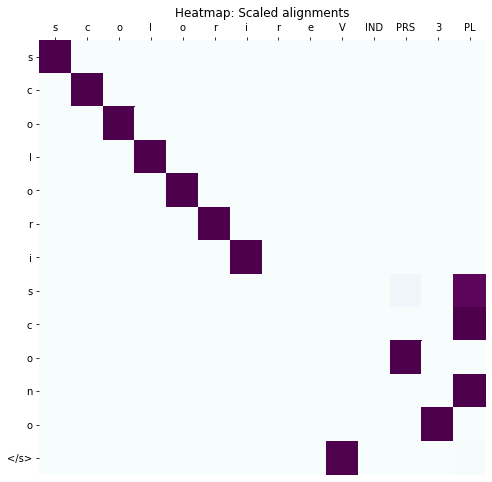

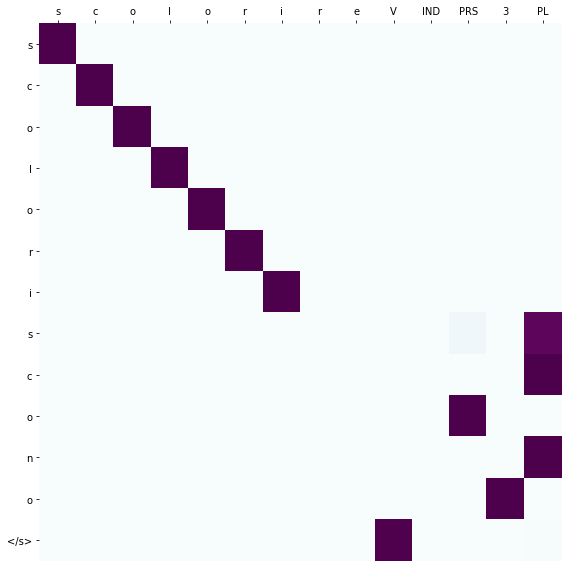

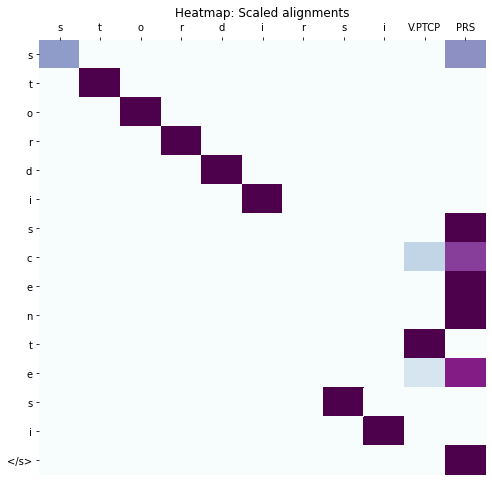

In [13]:
# OBSOLETE
#attn sparsemax
attn_file='{}/{}/separate-gate-sparse-03-adapt.ymp-{}-models/predict/dev.pred.{}.attn'.format(exp_dir,lang,batch_size, beam_size)

attn_data=torch.load(attn_file)

scaled_al_heatmap(attn_data,84)
scaled_al_heatmap(attn_data,84, save_file='{}/{}/intro-ex-beam4.png'.format(exp_dir,lang))

scaled_al_heatmap(attn_data,15)


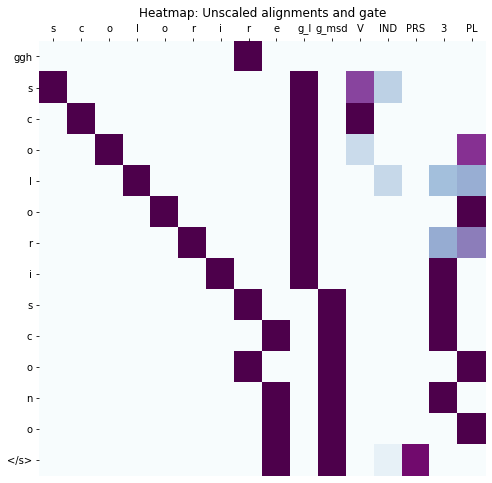

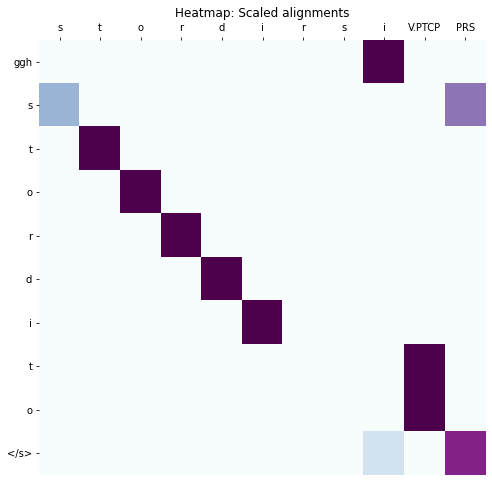

In [14]:
# OBSOLETE
#attn sparsemax with global gate head, gate is over global(char) head only
#attn_file='/mnt/conll/sigm-data/2018/russian/sparsemax-global-gate-head.ymp-models/predict/dev.pred.attn'
attn_file='{}/{}/sparsemax-ggh-comb.ymp-{}-models/predict/dev.pred.{}.attn'.format(exp_dir,lang,batch_size,beam_size)

attn_ggh_data=torch.load(attn_file)
unscaled_al_ggh_heatmap(attn_ggh_data,84,n_global_heads=1)
scaled_al_ggh_heatmap(attn_ggh_data,15,n_global_heads=1)

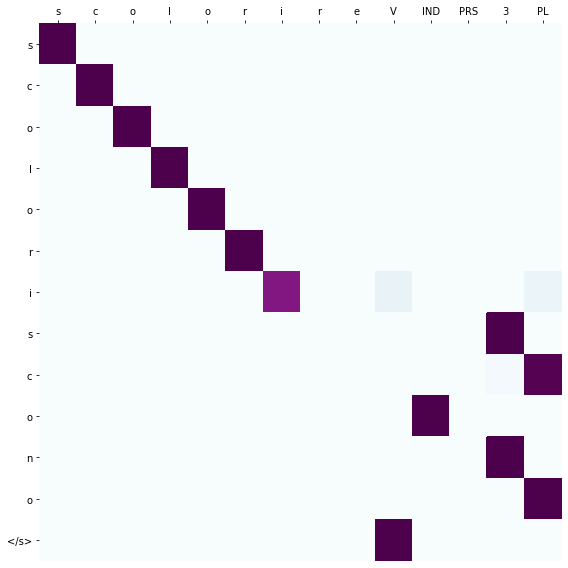

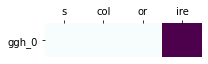

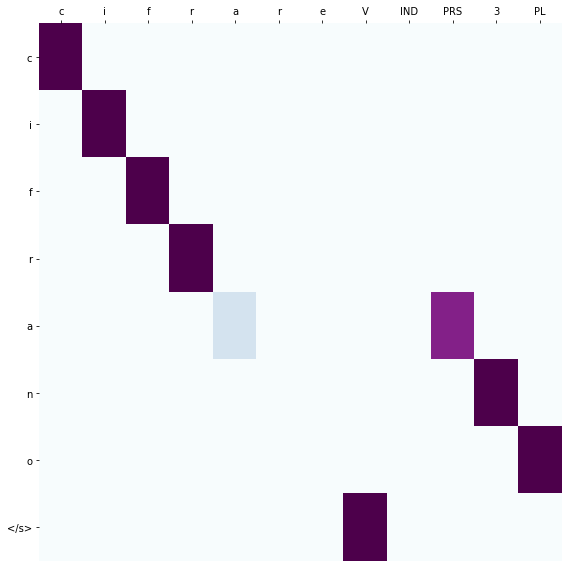

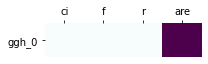

In [30]:
#attn sparsemax with global gate head, gate is over global(bpe) and local
# bpe 1000
attn_file='{}/{}/sparsemax-ggh-bpe-comb.ymp-{}-{}-models/predict/dev.pred.{}.attn'.format(exp_dir,lang,bpe_n,batch_size,beam_size)
attn_ggh_bpe_data_comb=torch.load(attn_file)
bpe_data = '{}/{}/{}-dev-bpe-{}'.format(exp_dir,lang,lang,bpe_n)
scaled_al_ggh_heatmap(attn_ggh_bpe_data_comb,84, bpe=True, bpe_data=bpe_data, n_global_heads=1, save_file='{}/{}/intro-ex-beam4-subs'.format(exp_dir,lang))


attn_file='{}/{}/sparsemax-ggh-bpe-comb.ymp-{}-{}-models/predict/train-high.pred.{}.attn'.format(exp_dir,lang,bpe_n,batch_size,beam_size)
attn_ggh_bpe_data_comb=torch.load(attn_file)
bpe_data = '{}/{}/{}-train-high-bpe-{}'.format(exp_dir,lang,lang,bpe_n)
scaled_al_ggh_heatmap(attn_ggh_bpe_data_comb,7272, bpe=True, bpe_data=bpe_data, n_global_heads=1, save_file='{}/{}/ex7272-train-beam4-subs'.format(exp_dir,lang))

#print(attn_ggh_bpe_data_comb[68])

In [16]:
# gold files
gold_file_dev='{}/{}/{}-dev'.format(exp_dir,lang,lang)
gold_file_train='{}/{}/{}-train-high'.format(exp_dir,lang,lang)
gold_file_test='{}/{}/{}-test'.format(exp_dir,lang,lang)
gold_files = [gold_file_dev, gold_file_train, gold_file_test]


In [17]:
#attn sparsemax with global gate head, gate is over global(bpe) and local
attn_file_dev='{}/{}/sparsemax-ggh-bpe-comb.ymp-{}-{}-models/predict/dev.pred.{}.attn'.format(exp_dir,lang,bpe_n,batch_size,beam_size)
attn_file_train='{}/{}/sparsemax-ggh-bpe-comb.ymp-{}-{}-models/predict/train-high.pred.{}.attn'.format(exp_dir,lang,bpe_n,batch_size,beam_size)
attn_file_test='{}/{}/sparsemax-ggh-bpe-comb.ymp-{}-{}-models/predict/test.pred.{}.attn'.format(exp_dir,lang,bpe_n,batch_size,beam_size)

attn_files = [attn_file_dev, attn_file_train, attn_file_test]

attn_data = []
for f in attn_files:
    attn_data.extend(torch.load(f))

partial_msd='V;'    
    
pattern_list = data2patterns(attn_data, allow_double_al=False)
phen_dict_regr, phen_dict_regr_freq, phen_dict_regr_acc = msd2pattern(partial_msd,
                                                                      attn_data,pattern_list,gold_files)
print(phen_dict_regr.keys())                                                                      
phen_msd = 'V;IND;PRS;3;PL'

print_frequent_patterns(phen_msd, phen_dict_regr, 
                            phen_dict_regr_freq, phen_dict_regr_acc, n=15)


dict_keys(['V;COND;3;SG', 'V;IND;FUT;3;PL', 'V;IND;PST;1;PL;PFV', 'V;IND;PST;1;SG;PFV', 'V;IND;PRS;2;SG', 'V;IND;PRS;3;SG', 'V;SBJV;PRS;3;SG', 'V;IND;PST;3;SG;IPFV', 'V;COND;1;PL', 'V;IND;PST;2;SG;IPFV', 'V;IND;PST;2;PL;IPFV', 'V;POS;IMP;2;SG', 'V;IND;FUT;2;SG', 'V;SBJV;PRS;3;PL', 'V;IND;PST;1;PL;IPFV', 'V;IND;FUT;2;PL', 'V;POS;IMP;3;PL', 'V;NFIN', 'V;IND;PRS;1;PL', 'V;IND;FUT;1;PL', 'V;SBJV;PRS;1;PL', 'V;IND;PST;2;SG;PFV', 'V;POS;IMP;1;PL', 'V;COND;3;PL', 'V;POS;IMP;3;SG', 'V;COND;2;SG', 'V;SBJV;PRS;2;SG', 'V;IND;FUT;1;SG', 'V;SBJV;PST;1;PL', 'V;IND;PST;1;SG;IPFV', 'V;IND;PRS;2;PL', 'V;IND;PRS;1;SG', 'V;SBJV;PST;2;PL', 'V;IND;FUT;3;SG', 'V;COND;1;SG', 'V;SBJV;PST;3;PL', 'V;POS;IMP;2;PL', 'V;IND;PRS;3;PL', 'V;SBJV;PST;2;SG', 'V;IND;PST;2;PL;PFV', 'V;SBJV;PRS;2;PL', 'V;IND;PST;3;PL;PFV', 'V;SBJV;PST;3;SG', 'V;IND;PST;3;PL;IPFV', 'V;IND;PST;3;SG;PFV', 'V;SBJV;PST;1;SG', 'V;SBJV;PRS;1;SG', 'V;COND;2;PL'])
MSD V;IND;PRS;3;PL, frequency: 255, accuracy: 0.992157

frequency: 149, coverage: 0.

In [18]:
# DECISIONS
#attn sparsemax with global gate head, gate is over global(bpe) and local
attn_file_dev='{}/{}/sparsemax-ggh-bpe-comb.ymp-{}-{}-models/predict/dev.pred.{}.attn'.format(exp_dir,lang,bpe_n,batch_size,beam_size)
attn_file_train='{}/{}/sparsemax-ggh-bpe-comb.ymp-{}-{}-models/predict/train-high.pred.{}.attn'.format(exp_dir,lang,bpe_n,batch_size,beam_size)
attn_file_test='{}/{}/sparsemax-ggh-bpe-comb.ymp-{}-{}-models/predict/test.pred.{}.attn'.format(exp_dir,lang,bpe_n,batch_size,beam_size)

attn_files = [attn_file_dev, attn_file_train, attn_file_test]

attn_data = []
for f in attn_files:
    attn_data.extend(torch.load(f))

#print(attn_data[0])
    
bpe_file_dev='{}/{}/{}-dev-bpe-{}'.format(exp_dir,lang,lang,bpe_n)
bpe_file_train='{}/{}/{}-train-high-bpe-{}'.format(exp_dir,lang,lang,bpe_n)
bpe_file_test='{}/{}/{}-test-bpe-{}'.format(exp_dir,lang,lang,bpe_n)


bpe_files = [bpe_file_dev, bpe_file_train, bpe_file_test]



print('Form ends on scono')
partial_trg = 'scono'
partial_msd = 'V;IND;PRS;3;PL'

phen_dict = msd2decision(partial_msd,partial_trg,attn_data,
                         gold_files,bpe_files,pattern='end',
                         n_global_heads=1,pull_max=False,ave_threshold=False)
for k,v in phen_dict.items():
    if k=='phen':
        print('class:{}, acc: {}, freq: {}'.format(k,
                                               v['acc']/v['freq'], v['freq']))
        str_out=''
        for p,f in sorted(v['pat'].items(), key=lambda x:x[1]['freq'], reverse=True):
            #if f['freq']>10:
                #print('{}:{}'.format(p,f['freq']))
                #print('({})'.format(', '.join(f['ex'][:10])))
                str_out+='{}:{}/{} ({}), '.format(p,f['freq'],f['acc']/f['freq'],f['ex'][0])
print(str_out)
                
print('\nForm ends on ano')
partial_trg = 'ano'
partial_msd = 'V;IND;PRS;3;PL'

phen_dict = msd2decision(partial_msd,partial_trg,attn_data,
                         gold_files,bpe_files,pattern='end',
                         n_global_heads=1,pull_max=False,ave_threshold=False)

for k,v in phen_dict.items():
    if k=='phen':
        print('class:{}, acc: {}, freq: {}'.format(k,
                                               v['acc']/v['freq'], v['freq']))
        str_out=''
        for p,f in sorted(v['pat'].items(), key=lambda x:x[1]['freq'], reverse=True):
            #if f['freq']>10:
                #print('{}:{}'.format(p,f['freq']))
                #print('({})'.format(', '.join(f['ex'][:10])))
                str_out+='{}:{}/{} ({}), '.format(p,f['freq'],f['acc']/f['freq'],f['ex'][0])
print(str_out)
                
print('\nForm ends on ono')
partial_trg = 'ono'
partial_trg_1 = 'scono'
partial_msd = 'V;IND;PRS;3;PL'

#msd2decision(partial_MSD,partial_trg,attn_data,gold_files,
#                 bpe_files,pattern='start',n_global_heads=None,
#                 pull_max=False, ave_threshold=False, partial_trg_1=None, pattern_1='not_end')

phen_dict = msd2decision(partial_msd,partial_trg,attn_data,
                         gold_files,bpe_files,pattern='end',
                         n_global_heads=1,pull_max=False,ave_threshold=False,
                        partial_trg_1=partial_trg_1, pattern_1='not_end')

for k,v in phen_dict.items():
    if k=='phen':
        print('class:{}, acc: {}, freq: {}'.format(k,
                                               v['acc']/v['freq'], v['freq']))
        str_out=''
        for p,f in sorted(v['pat'].items(), key=lambda x:x[1]['freq'], reverse=True):
            #if f['freq']>10:
                #print('{}:{}'.format(p,f['freq']))
                #print('({})'.format(', '.join(f['ex'][:10])))
                str_out+='{}:{}/{} ({}), '.format(p,f['freq'],f['acc']/f['freq'],f['ex'][0])

print(str_out)

Form ends on scono
class:phen, acc: 1.0, freq: 23
*re:9/1.0 (903:in|z|o|ti|chi|re), *ire:7/1.0 (84:s|col|or|ire), *ir*:6/1.0 (2199:re|in|ser|ir|si), *cir*:1/1.0 (6042:in|fer|o|cir|si), 

Form ends on ano
class:phen, acc: 1.0, freq: 189
*are:149/1.0 (184:z|am|pic|are), *arsi:26/1.0 (232:im|pa|per|arsi), *car*:3/1.0 (3302:ri|mb|ec|car|si), *izzarsi:2/1.0 (607:dest|abil|izz|arsi), *iarsi:2/1.0 (948:di|lan|i|arsi), *par*:2/1.0 (6149:dis|col|par|si), *ciarsi:1/1.0 (4682:au|to|den|un|ci|arsi), *mar*:1/1.0 (6715:in|for|mar|si), *rarsi:1/1.0 (7337:gi|ost|r|arsi), *itarsi:1/1.0 (10462:ri|abil|it|arsi), *quar*:1/1.0 (10581:sci|ac|quar|si), 

Form ends on ono
class:phen, acc: 0.9512195121951219, freq: 41
*ere:19/0.9473684210526315 (209:ri|otten|ere), *dere:10/1.0 (1344:te|le|ve|dere), *ger*:3/1.0 (2648:cos|par|ger|si), *re:3/1.0 (7525:servi|re), *e:1/0.0 (267:ri|ro|m|per|e), *ir*:1/1.0 (1908:s|ent|ir|si), *si:1/1.0 (7914:es|p|or|si), *ire:1/1.0 (8706:ri|di|ven|ire), *er*:1/1.0 (11832:r|aggi|ung|e

In [19]:
# DECISIONS
#attn sparsemax with global gate head, gate is over global(bpe) and local
attn_file_dev='{}/{}/sparsemax-ggh-comb.ymp-{}-models/predict/dev.pred.{}.attn'.format(exp_dir,lang,batch_size,beam_size)
attn_file_train='{}/{}/sparsemax-ggh-comb.ymp-{}-models/predict/train-high.pred.{}.attn'.format(exp_dir,lang,batch_size,beam_size)
attn_file_test='{}/{}/sparsemax-ggh-comb.ymp-{}-models/predict/test.pred.{}.attn'.format(exp_dir,lang,batch_size,beam_size)

attn_files = [attn_file_dev, attn_file_train, attn_file_test]

attn_data = []
for f in attn_files:
    attn_data.extend(torch.load(f))

#print(attn_data[0])
    
bpe_file_dev='{}/{}/{}-dev-bpe-{}'.format(exp_dir,lang,lang,bpe_n)
bpe_file_train='{}/{}/{}-train-high-bpe-{}'.format(exp_dir,lang,lang,bpe_n)
bpe_file_test='{}/{}/{}-test-bpe-{}'.format(exp_dir,lang,lang,bpe_n)


bpe_files = [bpe_file_dev, bpe_file_train, bpe_file_test]



print('Form ends on scono')
partial_trg = 'scono'
partial_msd = 'V;IND;PRS;3;PL'

phen_dict = msd2decision(partial_msd,partial_trg,attn_data,
                         gold_files,bpe_files,pattern='end',
                         n_global_heads=1,pull_max=False,ave_threshold=False)
for k,v in phen_dict.items():
    if k=='phen':
        print('class:{}, acc: {}, freq: {}'.format(k,
                                               v['acc']/v['freq'], v['freq']))
        str_out=''
        for p,f in sorted(v['pat'].items(), key=lambda x:x[1]['freq'], reverse=True):
            #if f['freq']>10:
                #print('{}:{}'.format(p,f['freq']))
                #print('({})'.format(', '.join(f['ex'][:10])))
                str_out+='{}:{}/{} ({}), '.format(p,f['freq'],f['acc']/f['freq'],f['ex'][0])
print(str_out)
                
print('\nForm ends on ano')
partial_trg = 'ano'
partial_msd = 'V;IND;PRS;3;PL'

phen_dict = msd2decision(partial_msd,partial_trg,attn_data,
                         gold_files,bpe_files,pattern='end',
                         n_global_heads=1,pull_max=False,ave_threshold=False)

for k,v in phen_dict.items():
    if k=='phen':
        print('class:{}, acc: {}, freq: {}'.format(k,
                                               v['acc']/v['freq'], v['freq']))
        str_out=''
        for p,f in sorted(v['pat'].items(), key=lambda x:x[1]['freq'], reverse=True):
            #if f['freq']>10:
                #print('{}:{}'.format(p,f['freq']))
                #print('({})'.format(', '.join(f['ex'][:10])))
                str_out+='{}:{}/{} ({}), '.format(p,f['freq'],f['acc']/f['freq'],f['ex'][0])
print(str_out)
                
print('\nForm ends on ono')
partial_trg = 'ono'
partial_trg_1 = 'scono'
partial_msd = 'V;IND;PRS;3;PL'

#msd2decision(partial_MSD,partial_trg,attn_data,gold_files,
#                 bpe_files,pattern='start',n_global_heads=None,
#                 pull_max=False, ave_threshold=False, partial_trg_1=None, pattern_1='not_end')

phen_dict = msd2decision(partial_msd,partial_trg,attn_data,
                         gold_files,bpe_files,pattern='end',
                         n_global_heads=1,pull_max=False,ave_threshold=False,
                        partial_trg_1=partial_trg_1, pattern_1='not_end')

for k,v in phen_dict.items():
    if k=='phen':
        print('class:{}, acc: {}, freq: {}'.format(k,
                                               v['acc']/v['freq'], v['freq']))
        str_out=''
        for p,f in sorted(v['pat'].items(), key=lambda x:x[1]['freq'], reverse=True):
            #if f['freq']>10:
                #print('{}:{}'.format(p,f['freq']))
                #print('({})'.format(', '.join(f['ex'][:10])))
                str_out+='{}:{}/{} ({}), '.format(p,f['freq'],f['acc']/f['freq'],f['ex'][0])

print(str_out)

Form ends on scono
class:phen, acc: 1.0, freq: 23
*:23/1.0 (84:s|col|or|ire), 

Form ends on ano
class:phen, acc: 1.0, freq: 189
*:189/1.0 (184:z|am|pic|are), 

Form ends on ono
class:phen, acc: 0.9512195121951219, freq: 41
*:41/0.9512195121951219 (209:ri|otten|ere), 


In [20]:
#attn sparsemax with global gate head, gate is over global(bpe), global(char) and local

attn_file_dev='{}/{}/sparsemax-ggh-mix-comb.ymp-{}-models/predict/dev.pred.attn'.format(exp_dir,lang,bpe_n)
attn_file_train='{}/{}/sparsemax-ggh-mix-comb.ymp-{}-models/predict/train-high.pred.attn'.format(exp_dir,lang,bpe_n)
attn_file_test='{}/{}/sparsemax-ggh-mix-comb.ymp-{}-models/predict/test.pred.attn'.format(exp_dir,lang,bpe_n)

attn_files = [attn_file_dev, attn_file_train, attn_file_test]

attn_data = []
for f in attn_files:
    attn_data.extend(torch.load(f))

partial_msd = 'V;IND;PRS;3;SG'
pattern_list = data2patterns(attn_data, allow_double_al=False)
phen_dict_regr, phen_dict_regr_freq, phen_dict_regr_acc = msd2pattern(partial_msd,
                                                                      attn_data,pattern_list,
                                                                      gold_files)

phen_msd = 'V;IND;PRS;3;SG'
print_frequent_patterns(phen_msd, phen_dict_regr, 
                            phen_dict_regr_freq, phen_dict_regr_acc, n=7)


MSD V;IND;PRS;3;SG, frequency: 217, accuracy: 0.972350

frequency: 124, coverage: 0.5714285714285714, accuracy: 0.9758064516129032
unmasekd_pattern:  c1 r e --> c1
frequency by pattern:  {'c1 r e --> c1': 124}
alignments and masks for the most frequent masked pattern:

___mask2src_after_unmasking: c1: average length of 7.8

___mask2trg_after_unmasking: c1: average length of 7.8

IDs: 227 : perplimere : perplime, 389 : controllare : controlla, 606 : riproteggere : riprotegge, 708 : spalancare : spalanca, 819 : inzuppare : inzuppa, 820 : sminuzzare : sminuzza, 823 : riscorrere : riscorre, 825 : incazzare : incazza, 929 : agglomerare : agglomera, 941 : strabere : strabe(gold: strabeve), 993 : deionizzare : deionizza, 1101 : confutare : confuta, 1211 : ammodernare : ammoderna, 1367 : prefabbricare : prefabbrica, 1378 : paraffinare : paraffina, 1421 : trasecolare : trasecola, 1468 : armonizzare : armonizza, 1474 : resistere : resiste, 1493 : misturare : mistura, 1540 : personificare : perso

In [21]:
# DECISIONS
#attn sparsemax with global gate head, gate is over global(bpe), global(char) and local
# bpe 1000
attn_file_dev='{}/{}/sparsemax-ggh-mix-comb.ymp-{}-models/predict/dev.pred.attn'.format(exp_dir,lang,bpe_n)
attn_file_train='{}/{}/sparsemax-ggh-mix-comb.ymp-{}-models/predict/train-high.pred.attn'.format(exp_dir,lang,bpe_n)
attn_file_test='{}/{}/sparsemax-ggh-mix-comb.ymp-{}-models/predict/test.pred.attn'.format(exp_dir,lang,bpe_n)

attn_files = [attn_file_dev, attn_file_train, attn_file_test]

attn_data = []
for f in attn_files:
    attn_data.extend(torch.load(f))

#print(attn_data[0])
    
bpe_file_dev='{}/{}/{}-dev-bpe-{}'.format(exp_dir,lang,lang,bpe_n)
bpe_file_train='{}/{}/{}-train-high-bpe-{}'.format(exp_dir,lang,lang,bpe_n)
bpe_file_test='{}/{}/{}-test-bpe-{}'.format(exp_dir,lang,lang,bpe_n)

bpe_files = [bpe_file_dev, bpe_file_train, bpe_file_test]

print('Form has a space')
partial_trg = ' '
partial_msd = 'V;IND;PRS'

print('Form contains um')
partial_trg = 'um'
partial_msd = 'V;IPFV;AGFOC'

phen_dict = msd2decisionMIX(partial_msd,partial_trg,attn_data,
                         gold_files,bpe_files,pattern='in',
                         pull_max=False,ave_threshold=False)
for k,v in phen_dict.items():
    if k=='phen':
        print('class:{}, acc: {}, freq: {}'.format(k,
                                               v['acc']/v['freq'], v['freq']))
        for p,f in sorted(v['pat'].items(), key=lambda x:x[1]['freq'], reverse=True):
            if f['freq']>=2:
                print('{}:{}'.format(p,f['freq']))
                print('({})'.format(', '.join(f['ex'][:10])))


print('Form start with nag')
partial_trg = 'nag-'
partial_msd = 'V;IPFV;AGFOC'

phen_dict = msd2decision(partial_msd,partial_trg,attn_data,
                         gold_files,bpe_files,pattern='start',
                         pull_max=False,ave_threshold=False)
for k,v in phen_dict.items():
    if k=='phen':
        print('class:{}, acc: {}, freq: {}'.format(k,
                                               v['acc']/v['freq'], v['freq']))
        for p,f in sorted(v['pat'].items(), key=lambda x:x[1]['freq'], reverse=True):
            if f['freq']>=2:
                print('{}:{}'.format(p,f['freq']))
                print('({})'.format(', '.join(f['ex'][:10])))

Form has a space
Form contains um


ZeroDivisionError: division by zero

In [ ]:
# sparse double attn
attn_file_dev='{}/{}/separate-gate-sparse-03-adapt.ymp-models/predict/dev.pred.attn'.format(exp_dir,lang)
attn_file_train='{}/{}/separate-gate-sparse-03-adapt.ymp-models/predict/train-high.pred.attn'.format(exp_dir,lang)
attn_file_test='{}/{}/separate-gate-sparse-03-adapt.ymp-models/predict/test.pred.attn'.format(exp_dir,lang)

attn_files = [attn_file_dev, attn_file_train, attn_file_test]

attn_data = []
for f in attn_files:
    attn_data.extend(torch.load(f))

pattern_list = data2patterns(attn_data, allow_double_al=False)
phen_dict_regr, phen_dict_regr_freq, phen_dict_regr_acc = msd2pattern(partial_msd,
                                                                      attn_data,pattern_list,
                                                                      gold_files)
phen_msd = 'V;IND;PRS;3;SG'
print_frequent_patterns(phen_msd, phen_dict_regr, 
                            phen_dict_regr_freq, phen_dict_regr_acc, n=5)


In [ ]:
#attn sparsemax with global gate head, gate is over global(bpe), global(char) and local
# bpe 1000
attn_file='{}/{}/sparsemax-ggh-mix-comb.ymp-{}-models/predict/dev.pred.attn'.format(exp_dir,lang,bpe_n)

attn_ggh_bpe_data_comb=torch.load(attn_file)
bpe_data = '{}/{}/{}-dev-bpe-{}'.format(exp_dir,lang,lang,bpe_n)

scaled_al_ggh_heatmap(attn_ggh_bpe_data_comb,413, bpe=True, bpe_data=bpe_data, n_global_heads=1, mixed=True)
scaled_al_ggh_heatmap(attn_ggh_bpe_data_comb,545, bpe=True, bpe_data=bpe_data, n_global_heads=1, mixed=True)
scaled_al_ggh_heatmap(attn_ggh_bpe_data_comb,27, bpe=True, bpe_data=bpe_data, n_global_heads=1, mixed=True)

#print(attn_ggh_bpe_data_comb[758])